In [60]:
import os
import numpy as np
import pandas as pd
import re
import nltk 
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

import tensorflow as tf
import tensorflow_hub as hub
from transformers import TFBertModel, BertTokenizerFast
from wordcloud import WordCloud
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Embedding, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate
from tensorflow.keras import initializers
from keras import constraints
from keras.layers import Lambda
from keras.layers import multiply
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


from keras.models import Model

from tensorflow.keras import regularizers

from tensorflow.keras.layers import RepeatVector

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier


In [15]:
laptop_df = pd.read_csv("Laptop_Train_v2.csv", encoding='utf8')


In [16]:
laptop_df.head()

,id,Sentence,Aspect Term,polarity,from,to
0,2339,I charge it at night and skip taking the cord ...,cord,neutral,41,45
1,2339,I charge it at night and skip taking the cord ...,battery life,positive,74,86
2,1316,The tech guy then said the service center does...,service center,negative,27,41
3,1316,The tech guy then said the service center does...,"""sales"" team",negative,109,121
4,1316,The tech guy then said the service center does...,tech guy,neutral,4,12


In [17]:
df = laptop_df

In [18]:
df

,id,Sentence,Aspect Term,polarity,from,to
0,2339,I charge it at night and skip taking the cord ...,cord,neutral,41,45
1,2339,I charge it at night and skip taking the cord ...,battery life,positive,74,86
2,1316,The tech guy then said the service center does...,service center,negative,27,41
3,1316,The tech guy then said the service center does...,"""sales"" team",negative,109,121
4,1316,The tech guy then said the service center does...,tech guy,neutral,4,12
...,...,...,...,...,...,...
2353,2272,We also use Paralles so we can run virtual mac...,Windows Server Enterprise 2003,neutral,104,134
2354,2272,We also use Paralles so we can run virtual mac...,Windows Server 2008 Enterprise,neutral,140,170
2355,848,"How Toshiba handles the repair seems to vary, ...",repair,conflict,24,30
2356,848,"How Toshiba handles the repair seems to vary, ...",repair,positive,130,136


In [19]:
df.columns

Index(['id', 'Sentence', 'Aspect Term', 'polarity', 'from', 'to'], dtype='object')

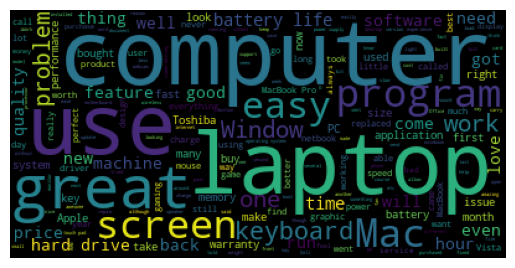

In [20]:
text3 = ' '.join(df['Sentence'])
wordcloud2 = WordCloud().generate(text3)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [21]:
## display the columns of the dataframe
df.columns

Index(['id', 'Sentence', 'Aspect Term', 'polarity', 'from', 'to'], dtype='object')

In [22]:
df['polarity'].isna().sum()

0

In [23]:
df.head()

,id,Sentence,Aspect Term,polarity,from,to
0,2339,I charge it at night and skip taking the cord ...,cord,neutral,41,45
1,2339,I charge it at night and skip taking the cord ...,battery life,positive,74,86
2,1316,The tech guy then said the service center does...,service center,negative,27,41
3,1316,The tech guy then said the service center does...,"""sales"" team",negative,109,121
4,1316,The tech guy then said the service center does...,tech guy,neutral,4,12


In [24]:
## change the labels to integers for the training phase
df['polarity'][df["polarity"] == 'negative'] = 0
df['polarity'][df["polarity"] == 'positive'] = 1
df['polarity'][df["polarity"] == 'neutral'] = 2


C:\Users\HP\AppData\Local\Temp\ipykernel_24864\2031586369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity'][df["polarity"] == 'negative'] = 0
C:\Users\HP\AppData\Local\Temp\ipykernel_24864\2031586369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity'][df["polarity"] == 'positive'] = 1
C:\Users\HP\AppData\Local\Temp\ipykernel_24864\2031586369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarit

In [25]:
#Delete the useless Columns 
train_df = df.drop(['id','from','to'], axis = 1)

In [26]:
Aspects_term = train_df['polarity'].unique()
Aspects_term[:20]

array([2, 1, 0, 'conflict'], dtype=object)

# train_df.head()

In [28]:
train_df[train_df.polarity == 'conflict']

,Sentence,Aspect Term,polarity
30,"-No backlit keyboard, but not an issue for me.",keyboard,conflict
39,"I did have to replace the battery once, but th...",battery,conflict
170,"Yes, they cost more, but they more than make u...",cost,conflict
177,It absolutely is more expensive than most PC l...,pricetag,conflict
241,"It has no camera but, I can always buy and ins...",camera,conflict
269,Small screen somewhat limiting but great for t...,screen,conflict
321,The video chat is the only thing that is iffy ...,quality,conflict
375,A longer battery life would have been great - ...,battery life,conflict
438,"The Apple will run Internet Explorer, but at a...",Internet Explorer,conflict
481,The macbook rarely requires a hard reboot.,hard reboot,conflict


In [29]:
## Delete the polarity than contains CONFLICT, Means that the sentence contains more than one sentiment when it comes to the aspect term
train_df.drop(train_df[train_df.polarity == 'conflict'].index, inplace = True)

In [30]:
## Training data shape 
df.shape

(2358, 6)

In [31]:
train_df[train_df.polarity == 'positive']

,Sentence,Aspect Term,polarity


In [32]:
train_df[train_df.polarity == 'negative']

,Sentence,Aspect Term,polarity


In [33]:
train_df[train_df.polarity == 'neutral']

,Sentence,Aspect Term,polarity


<AxesSubplot: >

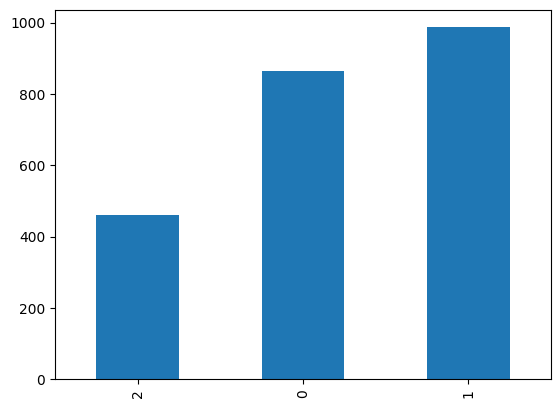

In [34]:
# Polarities distribution in our dataset
train_df.polarity.value_counts().sort_values().plot(kind = 'bar')


In [35]:
## Convert polarity Values to Integers 
train_df["polarity"] = pd.to_numeric(train_df["polarity"],errors='coerce')


In [36]:
## Display our training Dataframe 
train_df.head()

,Sentence,Aspect Term,polarity
0,I charge it at night and skip taking the cord ...,cord,2
1,I charge it at night and skip taking the cord ...,battery life,1
2,The tech guy then said the service center does...,service center,0
3,The tech guy then said the service center does...,"""sales"" team",0
4,The tech guy then said the service center does...,tech guy,2


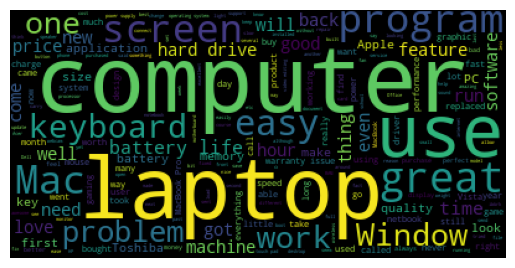

In [37]:
text3 = ' '.join(train_df['Sentence'])
wordcloud2 = WordCloud().generate(text3)
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [38]:
## drop the NAN Values from the dataframe
train_df.dropna(subset = ['polarity'], inplace = True)

In [39]:
## Verify if the dataframe contains any NAN Values
train_df.isna().sum()

Sentence       0
Aspect Term    0
polarity       0
dtype: int64

In [40]:
## Split the Dataset into Training and Testing Datasets
X_train, X_test, y_train, y_test = train_test_split(train_df,train_df['polarity'],stratify=train_df['polarity'], test_size=0.2, random_state=1)



In [41]:
# the size of the training dataset
X_train.Sentence.size

1850

In [42]:
# Display the shape of the target values!
y_train.shape

(1850,)

In [43]:
NUM_WORDS = 100000 ## MAx of words to keep, based on word frequency.
EMBEDDING_SIZE = 128 ## the length of the Vector the will 

In [44]:
#Embedding code

tokenizer = Tokenizer(num_words=NUM_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True, )
## Fit_on_texts : Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(list(X_train.Sentence))
text_X_train_tokenized = tokenizer.texts_to_sequences(X_train.Sentence) # list of tokenized sentences
Aspect_X_train_tokenized = tokenizer.texts_to_sequences(X_train['Aspect Term']) # list of tokenized sentences
text_X_test_tokenized = tokenizer.texts_to_sequences(X_test.Sentence) # list of tokenized sentences
Aspect_X_test_tokenized = tokenizer.texts_to_sequences(X_test['Aspect Term']) # list of tokenized sentences



In [45]:
##Maximum length of sentences
Max_Len =  max([len(one_title) for one_title in text_X_train_tokenized])
Max_Len

77

In [46]:
## Pads sequences(or sentences) to the same length.


text_X_train_padded = pad_sequences(text_X_train_tokenized, maxlen=Max_Len)
aspect_X_train_padded = pad_sequences(Aspect_X_train_tokenized, maxlen=1)

text_X_test_padded = pad_sequences(text_X_test_tokenized, maxlen=Max_Len)
aspect_X_test_padded = pad_sequences(Aspect_X_test_tokenized, maxlen=1)


In [47]:
## the embedding presentation of the aspects
aspect_X_train_padded[0]

array([1186])

In [48]:
## the embedding presentation of the Sentences

text_X_train_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   29, 1186,  176])

In [49]:
## Concatenate the Embedding presentation of the sentences and aspects to Create training and testing dataset 
train_data =  [text_X_train_padded,aspect_X_train_padded]
test_data =   [text_X_test_padded,aspect_X_test_padded]

In [50]:
test_data[1][0]

array([1487])

In [51]:
## Attention Mechanism

class Attention(Layer):

    def __init__(self, W_regularizer=None, u_regularizer=None, b_regularizer=None, W_constraint=None,
                 u_constraint=None, b_constraint=None, use_W=True, use_bias=False, return_self_attend=False,
                 return_attend_weight=True, **kwargs):
        self.supports_masking = True

        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.use_W = use_W
        self.use_bias = use_bias
        self.return_self_attend = return_self_attend    # whether perform self attention and return it
        self.return_attend_weight = return_attend_weight    # whether return attention weight
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        if self.use_W:
            self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),  initializer=self.init,
                                     name='{}_W'.format(self.name), regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)
        if self.use_bias:
            self.b = self.add_weight(shape=(input_shape[1],), initializer='zero', name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer, constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],), initializer=self.init, name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer, constraint=self.u_constraint)
        
        super(Attention, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        if self.use_W:
            x = K.tanh(K.dot(x, self.W))

        ait = Attention.dot_product(x, self.u)
        if self.use_bias:
            ait += self.b

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        if self.return_self_attend:
            attend_output = K.sum(x * K.expand_dims(a), axis=1)
            if self.return_attend_weight:
                return [attend_output, a]
            else:
                return attend_output
        else:
            return a

    def compute_output_shape(self, input_shape):
        if self.return_self_attend:
            if self.return_attend_weight:
                return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[1])]
            else:
                return input_shape[0], input_shape[-1]
        else:
            return input_shape[0], input_shape[1]

    @staticmethod
    def dot_product(x, kernel):
       
        if K.backend() == 'tensorflow':
            return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
        else:
            return K.dot(x, kernel)


In [ ]:
##LSTM with Aspect Embedding

In [52]:
def at_lstm(lstm_units = 512):
        input_text = Input(shape=(Max_Len,))
        input_aspect = Input(shape=(1,),)
        
        word_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
        text_embed = SpatialDropout1D(0.2)(word_embedding(input_text))
    
        asp_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
        aspect_embed = asp_embedding(input_aspect)
        aspect_embed = Flatten()(aspect_embed)  # reshape to 2d
        repeat_aspect = RepeatVector(Max_Len)(aspect_embed)  # repeat aspect for every word in sequence
        hidden_vecs = LSTM(lstm_units, return_sequences=True)(text_embed)  # hidden vectors output by lstm
        concat = concatenate([hidden_vecs, repeat_aspect], axis=-1)  # mask after concatenate will be same as hidden_out's mask
        print(concat.shape)
         # apply attention mechanism
        attend_weight = Attention()(concat)
        attend_weight_expand = Lambda(lambda x: K.expand_dims(x))(attend_weight)
        attend_hidden = multiply([hidden_vecs, attend_weight_expand])
        attend_hidden = Lambda(lambda x: K.sum(x, axis=1))(attend_hidden)
        Dense_layer  = Dense(128, activation='relu')(attend_hidden)
        output_layer = Dense(3, activation='softmax')(Dense_layer)
        return Model([input_text, input_aspect], output_layer)

In [53]:
at_lstm_model =  at_lstm()
at_lstm_model.summary()

(None, 77, 640)


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 77)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 77, 128)      12800000    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 128)       12800000    ['input_2[0][0]']                
                                                                                              

In [64]:
y_train.size

1850

In [ ]:
##LSTM with Aspect Embedding

In [76]:
def ae_lstm(lstm_units = 512):
    input_text = Input(shape=(Max_Len,))
    input_aspect = Input(shape=(1,),)
    
    word_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    text_embed = SpatialDropout1D(0.2)(word_embedding(input_text))
    
    asp_embedding = Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=Max_Len)
    aspect_embed = asp_embedding(input_aspect)
    
    
    aspect_embed = Flatten()(aspect_embed)  # reshape to 2d
    repeat_aspect = RepeatVector(Max_Len)(aspect_embed)  # repeat aspect for every word in sequence

    input_concat = concatenate([text_embed, repeat_aspect], axis=-1)
    hidden = LSTM(lstm_units)(input_concat)
    Dense_layer  = Dense(128, activation='relu')(hidden)
    output_layer = Dense(3, activation='softmax')(Dense_layer)
    return Model([input_text, input_aspect], output_layer)

In [77]:
ae_lstm_model = ae_lstm()
ae_lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 77)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 128)       12800000    ['input_4[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 77, 128)      12800000    ['input_3[0][0]']                
                                                                                            

In [78]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(ae_lstm_model, to_file=d   ot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [80]:
y_train.size

1850

In [ ]:
#Model training


In [81]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                    patience = 1,
                                                    verbose=1,
                                                    factor=0.1,
                                                    min_lr=0.000001)
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.01)

ae_lstm_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
history =  ae_lstm_model.fit(x = train_data, y = y_train,validation_data = (test_data, y_test), batch_size=16, epochs=20, callbacks = [learning_rate_reduction])

Epoch 1/20
116/116 [==============================] - 97s 816ms/step - loss: 1.1170 - accuracy: 0.4984 - val_loss: 0.9344 - val_accuracy: 0.5788 - lr: 0.0100
Epoch 2/20
116/116 [==============================] - 94s 808ms/step - loss: 0.7789 - accuracy: 0.6649 - val_loss: 0.8958 - val_accuracy: 0.5810 - lr: 0.0100
Epoch 3/20
116/116 [==============================] - 95s 817ms/step - loss: 0.5855 - accuracy: 0.7730 - val_loss: 0.9305 - val_accuracy: 0.5918 - lr: 0.0100
Epoch 4/20
116/116 [==============================] - 94s 810ms/step - loss: 0.4499 - accuracy: 0.8227 - val_loss: 1.0642 - val_accuracy: 0.6026 - lr: 0.0100
Epoch 5/20
116/116 [==============================] - 94s 812ms/step - loss: 0.3739 - accuracy: 0.8659 - val_loss: 1.1064 - val_accuracy: 0.6328 - lr: 0.0100
Epoch 6/20
116/116 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.8789
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
116/116 [=============================

In [ ]:
##Model Evaluation

In [82]:
text_X_test_padded[6].shape

(77,)

In [83]:
val_data =   [text_X_test_padded[6].reshape(1,Max_Len),aspect_X_test_padded[6]]
print(val_data[0].shape)
ae_lstm_model.predict(val_data)

(1, 77)
1/1 [==============================] - 0s 367ms/step


array([[9.9849558e-01, 4.9755466e-04, 1.0068601e-03]], dtype=float32)

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [87]:
print("Evaluate on test data")
results = ae_lstm_model.evaluate(x = test_data , y = y_test )
print("test loss, test acc:", results)
print("Accuracy of the model is - " , results[1]*100 , "%")

Evaluate on test data
15/15 [==============================] - 4s 248ms/step - loss: 1.4223 - accuracy: 0.5983
test loss, test acc: [1.4222944974899292, 0.5982721447944641]
Accuracy of the model is -  59.82721447944641 %


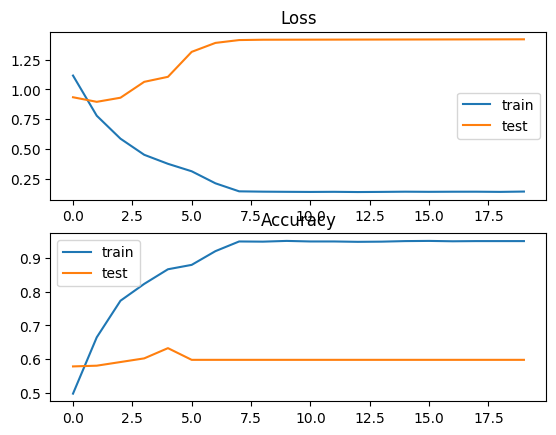

In [88]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()